In [1]:
import os
import numpy as np
import uproot3 as up3
import pandas
import matplotlib.pyplot as plt

,dm_type,n_chis,n_events
0,scalar,10391,58179.00000
1,scalar,21869,94594.00000
2,fermion,1000,22886.00000
3,fermion,13521,3.00429
4,fermion,6217,1.25228


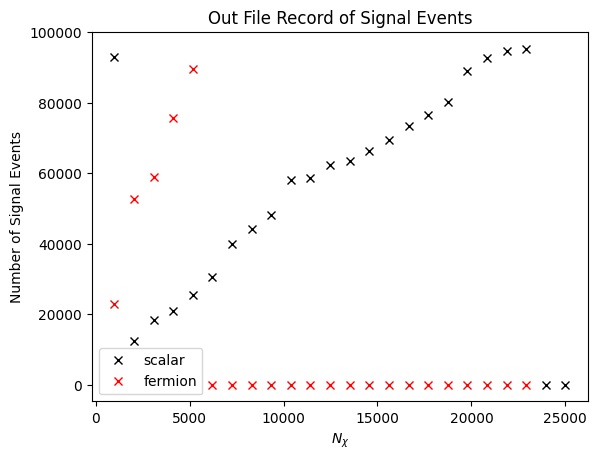

In [2]:
# plot the number of events in each file for the .out files
df = []
path_out = "../data/condor_out/out_signal_tests/"
for f in os.listdir(path_out):
    with open(path_out+f) as file:
        lines = file.readlines()
        n_chis = f.split(".")[-2][3:]
        #print(n_chis)
        for line in lines:
            if "DM type" in line:
                dmtp = line.strip("DM type =").strip("\n")
                #print(dmtp)
            if "Predicted number of signal events =" in line:
                df.append([dmtp, int(n_chis), float(line.split("= ")[-1][:-2])])


df = pandas.DataFrame(df, columns=["dm_type", "n_chis", "n_events"])
display(df.head())


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df[df["dm_type"]=="scalar"]["n_chis"], df[df["dm_type"]=="scalar"]["n_events"], "kx", label="scalar")
ax.plot(df[df["dm_type"]=="fermion"]["n_chis"], df[df["dm_type"]=="fermion"]["n_events"], "rx", label="fermion")
ax.set(title="Out File Record of Signal Events", xlabel=r"$N_\chi$", ylabel="Number of Signal Events")
#ax.set_ylim(-10, 10)
ax.legend()
plt.show()


Error in file n_chi_gen_23956.root
Error in file n_chi_gen_25000.root


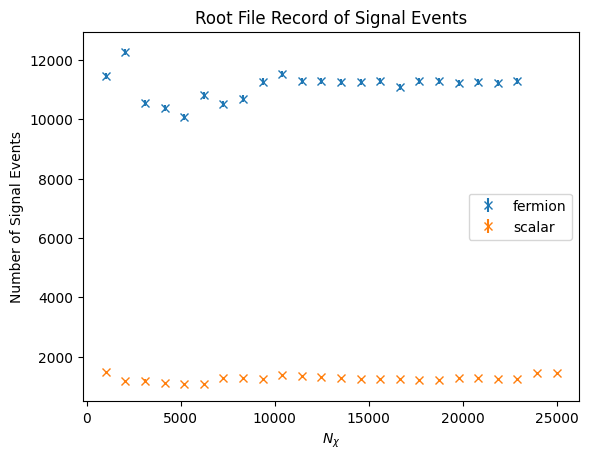

In [3]:
# In the root files
path_root = "../data/root/BdNMC/signal_tests/"

df = []

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title="Root File Record of Signal Events", xlabel=r"$N_\chi$", ylabel="Number of Signal Events")
for dm_type in ["fermion", "scalar"]:
    for file in os.listdir(path_root+dm_type):
        if "root" in file:
            n_chis = int(file.split("_")[-1].split(".")[0])
            with up3.open(path_root+dm_type+"/"+file) as f:
                try:
                    n_evts = f[b'elecron_tree;1'][b'electron_energy'].numentries
                    #print(n_chis, n_evts)
                    pot = f["pot_tree"]["tot_pot"].array()[0]
                    pmax = f["pot_tree"]["pmax"].array()[0]
                    pot_run1_numi = 1e21

                    n_electrons = n_evts * (pot_run1_numi / pot) * pmax

                    # assume posoin counting error roughly
                    n_electrons_err = np.sqrt(n_electrons)
                    df.append([dm_type, n_chis, n_electrons, n_electrons_err])
                except:
                    print("Error in file", file)
        
    df = pandas.DataFrame(df, columns=["dm_type", "n_chis", "n_events", "n_events_err"])
    ax.errorbar(df["n_chis"], df["n_events"], yerr=df["n_events_err"], fmt="x", label=dm_type)
    df = []

#ax.set_ylim(0, 3e3)
ax.legend()
plt.show()

Error in file n_chi_gen_23956.root
Error in file n_chi_gen_25000.root


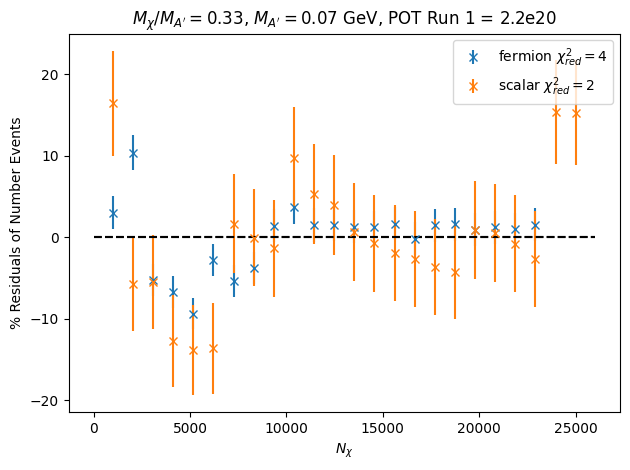

In [36]:
# In the root files

def chi_square(y,y_fit,err):
    return np.sum((y-y_fit)**2 / err**2)

def func(x):
    return np.zeros(len(x))

import scipy.optimize as o

# plot % residuals
path_root = "../data/root/BdNMC/signal_tests/"

df = []

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title=r"$M_\chi/M_{A'}=0.33$, $M_{A'}=0.07$ GeV, POT Run 1 = 2.2e20", xlabel=r"$N_\chi$", ylabel="% Residuals of Number Events")
for dm_type in ["fermion", "scalar"]:
    for file in os.listdir(path_root+dm_type):
        if "root" in file:
            n_chis = int(file.split("_")[-1].split(".")[0])
            with up3.open(path_root+dm_type+"/"+file) as f:
                try:
                    n_evts = f[b'elecron_tree;1'][b'electron_energy'].numentries
                    #print(n_chis, n_evts)
                    pot = f["pot_tree"]["tot_pot"].array()[0]
                    pmax = f["pot_tree"]["pmax"].array()[0]
                    pot_run1_numi = 2.2e20

                    n_electrons = n_evts * (pot_run1_numi / pot) * pmax

                    # assume posoin counting error roughly
                    n_electrons_err = np.sqrt(n_electrons)
                    df.append([dm_type, n_chis, n_electrons, n_electrons_err])
                except:
                    print("Error in file", file)
        
    df = pandas.DataFrame(df, columns=["dm_type", "n_chis", "n_events", "n_events_err"])
    #ax.errorbar(df["n_chis"], df["n_events"], yerr=df["n_events_err"], fmt="x", label=dm_type)
    avg_n_evts = df["n_events"].mean()
    df["residuals"] = (df["n_events"] - avg_n_evts) / avg_n_evts * 100
    yerr = df["n_events_err"].to_numpy() / avg_n_evts * 100
    dof = len(yerr)-1
    chi_sq_red = chi_square( df["residuals"].to_numpy(), func(df["residuals"].to_numpy()), yerr) / dof
    ax.errorbar(df["n_chis"], df["residuals"], yerr=yerr, fmt="x", label=dm_type + r" $\chi^2_{red}=$"+f"{chi_sq_red:.0f}")
    ax.plot([0,26000], [0,0], "k--")
    df = []

#ax.set_ylim(0, 3e3)
ax.legend()
fig.tight_layout()
plt.savefig("../plots/n_evts_check.pdf")
plt.show()